In [91]:
import theano
import theano.tensor as T
import numpy as np
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt

# Adam optimizer

In [92]:
class Adam:
    
    """Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., **kwargs):
        
        allowed_kwargs = {'clipnorm', 'clipvalue'}
        for k in kwargs:
            if k not in allowed_kwargs:
                raise TypeError('Unexpected keyword argument '
                                'passed to optimizer: ' + str(k))
        self.__dict__.update(kwargs)
        self.iterations = 0
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.decay = decay
        self.epsilon = epsilon
        self.initial_decay = decay

    def get_update(self, params, grads):
        """ params and grads are list of numpy arrays
        """
        original_shapes = [x.shape for x in params]
        params = [x.flatten() for x in params]
        grads = [x.flatten() for x in grads]
        
        """ #TODO: implement clipping
        if hasattr(self, 'clipnorm') and self.clipnorm > 0:
            norm = np.sqrt(sum([np.sum(np.square(g)) for g in grads]))
            grads = [clip_norm(g, self.clipnorm, norm) for g in grads]
        if hasattr(self, 'clipvalue') and self.clipvalue > 0:
            grads = [K.clip(g, -self.clipvalue, self.clipvalue) for g in grads]
        """
        
        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1
        lr_t = lr * (np.sqrt(1. - np.power(self.beta_2, t)) /
                     (1. - np.power(self.beta_1, t)))

        if not hasattr(self, 'ms'):
            self.ms = [np.zeros(p.shape) for p in params]
            self.vs = [np.zeros(p.shape) for p in params]
    
        ret = [None] * len(params)
        for i, p, g, m, v in zip(range(len(params)), params, grads, self.ms, self.vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * np.square(g)
            p_t = p - lr_t * m_t / (np.sqrt(v_t) + self.epsilon)
            self.ms[i] = m_t
            self.vs[i] = v_t
            ret[i] = p_t
        
        self.iterations += 1
        
        for i in range(len(ret)):
            ret[i] = ret[i].reshape(original_shapes[i])
        
        return ret


class SGD:
    """SGD optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
    """

    def __init__(self, lr=0.001, **kwargs):
        
        allowed_kwargs = {'clipnorm', 'clipvalue'}
        for k in kwargs:
            if k not in allowed_kwargs:
                raise TypeError('Unexpected keyword argument '
                                'passed to optimizer: ' + str(k))
        self.__dict__.update(kwargs)
        self.lr = lr

    def get_update(self, params, grads):
        """ params and grads are list of numpy arrays
        """
        original_shapes = [x.shape for x in params]
        params = [x.flatten() for x in params]
        grads = [x.flatten() for x in grads]
        
        """ #TODO: implement clipping
        if hasattr(self, 'clipnorm') and self.clipnorm > 0:
            norm = np.sqrt(sum([np.sum(np.square(g)) for g in grads]))
            grads = [clip_norm(g, self.clipnorm, norm) for g in grads]
        if hasattr(self, 'clipvalue') and self.clipvalue > 0:
            grads = [K.clip(g, -self.clipvalue, self.clipvalue) for g in grads]
        """
        
        ret = [None] * len(params)
        for i, p, g in zip(range(len(params)), params, grads):
            ret[i] = p - self.lr * g
        
        for i in range(len(ret)):
            ret[i] = ret[i].reshape(original_shapes[i])
        
        return ret

# Load Data

In [93]:
def load_data():
    with open('../data/EOD_week.pkl', 'rb') as f:
        df = pd.DataFrame(pkl.load(f))
    return df

df = load_data()
print("Data.shape = {}".format(df.shape))

Data.shape = (887, 5038)


In [102]:
X = df[0:200]
corex_params = {
    'n_hidden':10,
    'max_iter':100, # NOTE: 1e4
    'tol':1e-5,
    'anneal':True,
    'missing_values':None,
    'discourage_overlap':True,
    'gaussianize':'standard',
    'gpu':False,
    'verbose':True,
    'seed':None,
    'optimizer': Adam()
}

# Linear Corex SGD

In [119]:
""" Linear Total Correlation Explanation
Recovers linear latent factors from data, like PCA/ICA/FA, etc. except that
these factors are maximally informative about relationships in the data.
We also constrain our solutions to be "non-synergistic" for better interpretability.
(That is the TC(Y|Xi)=0 constraint in the "blessing of dimensionality" paper.)
Code below written by:
Greg Ver Steeg (gregv@isi.edu), 2017.
"""

from scipy.stats import norm, rankdata
import gc
try:
    import cudamat as cm
    GPU_SUPPORT = True
except:
    print("Install CUDA and cudamat (for python) to enable GPU speedups.")
    GPU_SUPPORT = False


class Corex(object):
    """
    Linear Total Correlation Explanation
    Conventions
    ----------
    Code follows sklearn naming/style (e.g. fit(X) to train, transform() to apply model to test data).
    Parameters
    ----------
    n_hidden : int, default = 2
        The number of latent factors to use.
    max_iter : int, default = 10000
        The max. number of iterations to reach convergence.
    tol : float, default = 0.0001
        Used to test for convergence.
    eliminate_synergy : bool, default = True
        Use a constraint that the information latent factors have about data is not synergistic.
    gaussianize : str, default = 'standard'
        Preprocess data so each marginal is near a standard normal. See gaussianize method for more details.
    yscale : float default = 1
        We imagine some small fundamental measurement noise on Y. The value is arbitrary, but it sets
        the scale of the results, Y.
    verbose : int, optional
        Print verbose outputs.
    seed : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    References
    ----------
    [1] Greg Ver Steeg and Aram Galstyan. "Maximally Informative Hierarchical...", AISTATS 2015.
    [2] Greg Ver Steeg, Shuyang Gao, Kyle Reing, and Aram Galstyan. "Sifting Common Information from Many Variables",
                                                                    IJCAI 2017.
    [3] Greg Ver Steeg and Aram Galstyan. "Low Complexity Gaussian Latent Factor Models and
                                           a Blessing of Dimensionality", 2017.
    """

    def __init__(self, n_hidden=10, max_iter=10000, tol=1e-5, anneal=True, missing_values=None,
                 discourage_overlap=True, gaussianize='standard', gpu=False,
                 verbose=False, seed=None, optimizer=SGD(lr=1e-2)):
        
        self.m = n_hidden  # Number of latent factors to learn
        self.max_iter = max_iter  # Number of iterations to try
        self.tol = tol  # Threshold for convergence
        self.anneal = anneal
        self.eps = 0  # If anneal is True, it's adjusted during optimization to avoid local minima
        self.missing_values = missing_values
        self.optimizer = optimizer

        self.discourage_overlap = discourage_overlap  # Whether or not to discourage overlapping latent factors
        self.gaussianize = gaussianize  # Preprocess data: 'standard' scales to zero mean and unit variance
        self.gpu = gpu  # Enable GPU support for some large matrix multiplications.
        if self.gpu:
            cm.cublas_init()

        self.yscale = 1.  # Can be arbitrary, but sets the scale of Y
        np.random.seed(seed)  # Set seed for deterministic results
        self.verbose = verbose
        if verbose:
            np.set_printoptions(precision=3, suppress=True, linewidth=160)
            print(('Linear CorEx with {:d} latent factors'.format(n_hidden)))

        # Initialize these when we fit on data
        self.n_samples, self.nv = 0, 0  # Number of samples/variables in input data
        self.ws = np.zeros((0, 0))  # m by nv array of weights
        self.moments = {}  # Dictionary of moments
        self.theta = None  # Parameters for preprocessing each variable
        self.history = {}  # Keep track of values for each iteration
        self.last_update = 0  # Used for momentum methods

    def fit_transform(self, x):
        self.fit(x, optimizer)
        return self.transform(x)

    def fit(self, x):
        x = np.asarray(x, dtype=np.float32)
        x = self.preprocess(x, fit=True)  # Fit a transform for each marginal
        self.n_samples, self.nv = x.shape  # Number of samples, variables in input data
        if self.m is None:
            self.m = pick_n_hidden(x)
        anneal_schedule = [0.]
        if self.ws.size == 0:  # Randomly initialize weights if not already set
            if self.discourage_overlap:
                self.ws = np.random.randn(self.m, self.nv).astype(np.float32)
                self.ws /= (10. * self._norm(x, self.ws))[:, np.newaxis]  # TODO: test good IC
                if self.anneal:
                    anneal_schedule = [0.6**k for k in range(1, 7)] + [0]
            else:
                self.ws = np.random.randn(self.m, self.nv) * self.yscale ** 2 / np.sqrt(self.nv)
        self.moments = self._calculate_moments(x, self.ws, quick=True)

        for i_eps, eps in enumerate(anneal_schedule):
            self.eps = eps
            if i_eps > 0:
                eps0 = anneal_schedule[i_eps - 1]
                mag = (1 - self.yscale**2 / self.moments['Y_j^2']).clip(1e-5)  # May be better to re-initialize un-used latent factors (i.e. yj^2=self.yscale**2)?
                wmag = np.sum(self.ws**2, axis=1)
                self.ws *= np.sqrt((1 - eps0**2) / (1 - eps**2 - (eps0**2 - eps**2) * wmag / mag))[:, np.newaxis]
            self.moments = self._calculate_moments(x, self.ws, quick=True)

            for i_loop in range(self.max_iter):
                last_tc = self.tc  # Save this TC to compare to possible updates
                if self.discourage_overlap:
                    self.ws, self.moments = self._update_ns(x)
                else:
                    self.ws, self.moments = self._update_syn(x, eta=0.1)  # Older method that allows synergies

                # assert np.isfinite(self.tc), "Error: TC is no longer finite: {}".format(self.tc)
                if not self.moments or not np.isfinite(self.tc):
                    try:
                        print(("Error: TC is no longer finite: {}".format(self.tc)))
                    except:
                        print("Error... updates giving invalid solutions?")
                        return self
                delta = np.abs(self.tc - last_tc)
                self.update_records(self.moments, delta)  # Book-keeping
                if delta < self.tol:  # Check for convergence
                    if self.verbose:
                        print(('{:d} iterations to tol: {:f}'.format(i_loop, self.tol)))
                    break
            else:
                if self.verbose:
                    print(("Warning: Convergence not achieved in {:d} iterations. "
                          "Final delta: {:f}".format(self.max_iter, delta.sum())))
        self.moments = self._calculate_moments(x, self.ws, quick=False)  # Update moments with details
        order = np.argsort(-self.moments["TCs"])  # Largest TC components first.
        self.ws = self.ws[order]
        self.moments = self._calculate_moments(x, self.ws, quick=False)  # Update moments based on sorted weights.
        return self

    def update_records(self, moments, delta):
        """Print and store some statistics about each iteration."""
        gc.disable()  # There's a bug that slows when appending, fixed by temporarily disabling garbage collection
        self.history["TC"] = self.history.get("TC", []) + [moments["TC"]]
        if self.verbose > 1:
            print(("TC={:.3f}\tadd={:.3f}\tdelta={:.6f}".format(moments["TC"], moments.get("additivity", 0), delta)))
        if self.verbose:
            self.history["additivity"] = self.history.get("additivity", []) + [moments.get("additivity", 0)]
            self.history["TCs"] = self.history.get("TCs", []) + [moments.get("TCs", np.zeros(self.m))]
        gc.enable()

    @property
    def tc(self):
        """This actually returns the lower bound on TC that is optimized. The lower bound assumes a constraint that
         would be satisfied by a non-overlapping model.
         Check "moments" for two other estimates of TC that may be useful."""
        return self.moments["TC"]

    @property
    def tcs(self):
        """TCs for each individual latent factor. They DO NOT sum to TC in this case, because of overlaps."""
        return self.moments["TCs"]

    @property
    def mis(self):
        return - 0.5 * np.log1p(-self.moments["rho"]**2)

    def clusters(self):
        return np.argmax(np.abs(self.ws), axis=0)

    def _sig(self, x, u):
        """Multiple the matrix u by the covariance matrix of x. We are interested in situations where
        n_variables >> n_samples, so we do this without explicitly constructing the covariance matrix."""
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            uc = cm.CUDAMatrix(u)
            cm.dot(x, uc.T, target=y)
            del uc
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del y
            del tmp
        else:
            y = x.dot(u.T)
            tmp_dot = x.T.dot(y)
        prod = (1 - self.eps**2) * tmp_dot.T / self.n_samples + self.eps**2 * u  # nv by m,  <X_i Y_j> / std Y_j
        return prod

    def _norm(self, x, ws):
        """Calculate uj so that we can normalize it."""
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            y_local = y.asarray()
            del y
            del wc
            tmp_sum = np.einsum('lj,lj->j', y_local, y_local)  # TODO: Should be able to do on gpu...
        else:
            y = x.dot(ws.T)  # + noise / std Y_j^2, but it is included analytically
            tmp_sum = np.einsum('lj,lj->j', y, y)
        return np.sqrt((1 - self.eps**2) * tmp_sum / self.n_samples + self.eps**2 * np.sum(ws**2, axis=1))

    def _calculate_moments(self, x, ws, quick=False):
        if self.discourage_overlap:
            return self._calculate_moments_ns(x, ws, quick=quick)
        else:
            return self._calculate_moments_syn(x, ws, quick=quick)

    def _calculate_moments_ns(self, x, ws, quick=False):
        """Calculate moments based on the weights and samples. We also calculate and save MI, TC, additivity, and
        the value of the objective. Note it is assumed that <X_i^2> = 1! """
        m = {}  # Dictionary of moments
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            del wc
            tmp_sum = np.einsum('lj,lj->j', y.asarray(), y.asarray())  # TODO: Should be able to do on gpu...
        else:
            y = x.dot(ws.T)
            tmp_sum = np.einsum('lj,lj->j', y, y)
        m["uj"] = (1 - self.eps**2) * tmp_sum / self.n_samples + self.eps**2 * np.sum(ws**2, axis=1)
#         if quick and np.max(m["uj"]) >= 1.:
#             return False
        if self.gpu:
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del tmp
            del y
        else:
            tmp_dot = x.T.dot(y)
        m["rho"] = (1 - self.eps**2) * tmp_dot.T / self.n_samples + self.eps**2 * ws  # m by nv
        m["ry"] = ws.dot(m["rho"].T)  # normalized covariance of Y
        m["Y_j^2"] = self.yscale ** 2 / (1. - m["uj"])
        np.fill_diagonal(m["ry"], 1)
        m["invrho"] = 1. / (1. - m["rho"]**2)
        m["rhoinvrho"] = m["rho"] * m["invrho"]
        m["Qij"] = np.dot(m['ry'], m["rhoinvrho"])
        m["Qi"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        #m["Qi-Si^2"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        m["Si"] = np.sum(m["rho"] * m["rhoinvrho"], axis=0)

        # This is the objective, a lower bound for TC
        m["TC"] = np.sum(np.log(1 + m["Si"])) \
                     - 0.5 * np.sum(np.log(1 - m["Si"]**2 + m["Qi"])) \
                     + 0.5 * np.sum(np.log(1 - m["uj"]))

        if not quick:
            m["MI"] = - 0.5 * np.log1p(-m["rho"]**2)
            m["X_i Y_j"] = m["rho"].T * np.sqrt(m["Y_j^2"])
            m["X_i Z_j"] = np.linalg.solve(m["ry"], m["rho"]).T
            m["X_i^2 | Y"] = (1. - np.einsum('ij,ji->i', m["X_i Z_j"], m["rho"])).clip(1e-6)
            m['I(Y_j ; X)'] = 0.5 * np.log(m["Y_j^2"]) - 0.5 * np.log(self.yscale ** 2)
            m['I(X_i ; Y)'] = - 0.5 * np.log(m["X_i^2 | Y"])
            m["TCs"] = m["MI"].sum(axis=1) - m['I(Y_j ; X)']
            m["TC_no_overlap"] = m["MI"].max(axis=0).sum() - m['I(Y_j ; X)'].sum()  # A direct calculation of TC where each variable is in exactly one group.
            m["TC_direct"] = m['I(X_i ; Y)'].sum() - m['I(Y_j ; X)']  # A direct calculation of TC. Should be upper bound for "TC", "TC_no_overlap"
            m["additivity"] = (m["MI"].sum(axis=0) - m['I(X_i ; Y)']).sum()
        return m
    
    def z2_fromW(self, j, W, x):
        # \eta^2 + W_j \Sigma W_j^T
        return self.yscale**2 + np.dot(self._sig(x, W[j:j+1,:]), W[j:j+1, :].T)

    def z2_fromU(self, j, U, x):
        # \frac{\eta^2}{1 - U_j \Sigma U_j^T}
        return (self.yscale**2) / (1 - np.dot(self._sig(x, U[j:j+1,:]), U[j:j+1, :].T))

    def getW(self, U, x):
        # W_{ji} = U_{ji} * \sqrt{E[Z_j^2]}
        W = np.zeros(U.shape)
        for j in range(U.shape[0]):
            W[j, :] = U[j, :] * np.sqrt(self.z2_fromU(j, U, x))
        return W

    def getU(self, W, x):
        # U_{ji} = \frac{W_{ji}}{\sqrt{E[Z_j^2]}}
        U = np.zeros(W.shape)
        for j in range(W.shape[0]):
            U[j, :] = W[j, :] / np.sqrt(self.z2_fromW(j, W, x))
        return U
    
    def _update_ns(self, x, return_gradient=False):
        """Perform one update of the weights and re-calculate moments in the NON-SYNERGISTIC case."""
        m = self.moments
        rj = 1. - m["uj"][:, np.newaxis]
        H = np.dot(m["rhoinvrho"] / (1 + m["Qi"] - m["Si"]**2), m["rhoinvrho"].T)
        np.fill_diagonal(H, 0)
        grad = self.ws / rj
        grad -= 2 * m["invrho"] * m["rhoinvrho"] / (1 + m["Si"])
        grad += m["invrho"]**2 * \
               ((1 + m["rho"]**2) * m["Qij"] - 2 * m["rho"] * m["Si"]) / (1 - m["Si"]**2 + m["Qi"])
        grad += np.dot(H, self.ws)
    
        if return_gradient:
            return grad
        
        # make a better gradient approximation by multipying each row by sqrt(E[zj^2])
        for j in range(self.ws.shape[0]):
            t = np.float(self.z2_fromU(j, self.ws, x))
            grad[j, :] *= np.sqrt(t)
        
        current_real_W = self.getW(self.ws, x)
        new_real_W = self.optimizer.get_update([current_real_W], [grad])[0]
        w_update = self.getU(new_real_W, x)
        m_update = self._calculate_moments_ns(x, w_update, quick=True)
        print "TC = {}, eps = {}".format(self.tc, self.eps)
        
        return w_update, m_update

    def _calculate_moments_syn(self, x, ws, quick=False):
        """Calculate moments based on the weights and samples. We also calculate and save MI, TC, additivity, and
        the value of the objective. Note it is assumed that <X_i^2> = 1! """
        m = {}  # Dictionary of moments
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            del wc
        else:
            y = x.dot(ws.T)  # + noise, but it is included analytically
        if self.gpu:
            tmp_dot = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp_dot)
            m["X_i Y_j"] = tmp_dot.asarray() / self.n_samples  # nv by m,  <X_i Y_j>
            del y
            del tmp_dot
        else:
            m["X_i Y_j"] = x.T.dot(y) / self.n_samples
        m["cy"] = ws.dot(m["X_i Y_j"]) + self.yscale ** 2 * np.eye(self.m)  # cov(y.T), m by m
        m["Y_j^2"] = np.diag(m["cy"]).copy()
        m["ry"] = m["cy"] / (np.sqrt(m["Y_j^2"]) * np.sqrt(m["Y_j^2"][:, np.newaxis]))
        m["rho"] = (m["X_i Y_j"] / np.sqrt(m["Y_j^2"])).T
        m["invrho"] = 1. / (1. - m["rho"]**2)
        m["rhoinvrho"] = m["rho"] * m["invrho"]
        m["Qij"] = np.dot(m['ry'], m["rhoinvrho"])
        m["Qi"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        m["Si"] = np.sum(m["rho"] * m["rhoinvrho"], axis=0)

        m["MI"] = - 0.5 * np.log1p(-m["rho"]**2)
        m["X_i Z_j"] = np.linalg.solve(m["cy"], m["X_i Y_j"].T).T
        m["X_i^2 | Y"] = (1. - np.einsum('ij,ij->i', m["X_i Z_j"], m["X_i Y_j"])).clip(1e-6)
        mi_yj_x = 0.5 * np.log(m["Y_j^2"]) - 0.5 * np.log(self.yscale ** 2)
        mi_xi_y = - 0.5 * np.log(m["X_i^2 | Y"])
        m["TCs"] = m["MI"].sum(axis=1) - mi_yj_x
        m["additivity"] = (m["MI"].sum(axis=0) - mi_xi_y).sum()
        m["TC"] = np.sum(mi_xi_y) - np.sum(mi_yj_x)
        return m

    def _update_syn(self, x, eta=0.5):
        """Perform one update of the weights and re-calculate moments in the SYNERGISTIC case."""
        m = self.moments
        H = (1. / m["X_i^2 | Y"] * m["X_i Z_j"].T).dot(m["X_i Z_j"])
        np.fill_diagonal(H, 0)
        R = m["X_i Z_j"].T / m["X_i^2 | Y"]
        S = np.dot(H, self.ws)
        ws = (1. - eta) * self.ws + eta * (R - S)
        m = self._calculate_moments_syn(x, ws)
        return ws, m

    def transform(self, x, details=False):
        """Transform an array of inputs, x, into an array of k latent factors, Y.
            Optionally, you can get the remainder information and/or stop at a specified level."""
        x = self.preprocess(x)
        ns, nv = x.shape
        assert self.nv == nv, "Incorrect number of variables in input, %d instead of %d" % (nv, self.nv)
        if details:
            moments = self._calculate_moments(x, self.ws)
            return x.dot(self.ws.T), moments
        return x.dot(self.ws.T)

    def preprocess(self, x, fit=False):
        """Transform each marginal to be as close to a standard Gaussian as possible.
        'standard' (default) just subtracts the mean and scales by the std.
        'empirical' does an empirical gaussianization (but this cannot be inverted).
        'outliers' tries to squeeze in the outliers
        Any other choice will skip the transformation."""
        if self.missing_values is not None:
            x, self.n_obs = mean_impute(x, self.missing_values)  # Creates a copy
        else:
            self.n_obs = len(x)
        if self.gaussianize == 'none':
            pass
        elif self.gaussianize == 'standard':
            if fit:
                mean = np.mean(x, axis=0)
                # std = np.std(x, axis=0, ddof=0).clip(1e-10)
                std = np.sqrt(np.sum((x - mean)**2, axis=0) / self.n_obs).clip(1e-10)
                self.theta = (mean, std)
            x = ((x - self.theta[0]) / self.theta[1])
            if np.max(np.abs(x)) > 6 and self.verbose:
                print("Warning: outliers more than 6 stds away from mean. Consider using gaussianize='outliers'")
        elif self.gaussianize == 'outliers':
            if fit:
                mean = np.mean(x, axis=0)
                std = np.std(x, axis=0, ddof=0).clip(1e-10)
                self.theta = (mean, std)
            x = g((x - self.theta[0]) / self.theta[1])  # g truncates long tails
        elif self.gaussianize == 'empirical':
            print("Warning: correct inversion/transform of empirical gauss transform not implemented.")
            x = np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        if self.gpu and fit:  # Don't return GPU matrices when only transforming
            x = cm.CUDAMatrix(x)
        return x

    def invert(self, x):
        """Invert the preprocessing step to get x's in the original space."""
        if self.gaussianize == 'standard':
            return self.theta[1] * x + self.theta[0]
        elif self.gaussianize == 'outliers':
            return self.theta[1] * g_inv(x) + self.theta[0]
        else:
            return x

    def predict(self, y):
        return self.invert(np.dot(self.moments["X_i Z_j"], y.T).T)

    def get_covariance(self):
        # This uses E(Xi|Y) formula for non-synergistic relationships
        m = self.moments
        if self.discourage_overlap:
            z = m['rhoinvrho'] / (1 + m['Si'])
            cov = np.dot(z.T, z)
            cov /= (1. - self.eps**2)
            np.fill_diagonal(cov, 1)
            return self.theta[1][:, np.newaxis] * self.theta[1] * cov
        else:
            cov = np.einsum('ij,kj->ik', m["X_i Z_j"], m["X_i Y_j"])
            np.fill_diagonal(cov, 1)
            return self.theta[1][:, np.newaxis] * self.theta[1] * cov


def pick_n_hidden(data, repeat=1, verbose=False):
    """A helper function to pick the number of hidden factors / clusters to use."""
    # TODO: Use an efficient search strategy
    max_score = - np.inf
    n = 1
    while True:
        scores = []
        for _ in range(repeat):
            out = Corex(n_hidden=n, max_iter=1000, tol=1e-3, gpu=False).fit(data)
            m = out.moments
            scores.append(m["TC_no_overlap"])
        score = max(scores)
        if verbose:
            print(("n: {}, score: {}".format(n, score)))
        if score < max_score:
            break
        else:
            n += 1
            max_score = score
    return n - 1


def g(x, t=4):
    """A transformation that suppresses outliers for a standard normal."""
    xp = np.clip(x, -t, t)
    diff = np.tanh(x - xp)
    return xp + diff


def g_inv(x, t=4):
    """Inverse of g transform."""
    xp = np.clip(x, -t, t)
    diff = np.arctanh(np.clip(x - xp, -1 + 1e-10, 1 - 1e-10))
    return xp + diff


def mean_impute(x, v):
    """Missing values in the data, x, are indicated by v. Wherever this value appears in x, it is replaced by the
    mean value taken from the marginal distribution of that column."""
    if not np.isnan(v):
        x = np.where(x == v, np.nan, x)
    x_new = []
    n_obs = []
    for i, xi in enumerate(x.T):
        missing_locs = np.where(np.isnan(xi))[0]
        xi_nm = xi[np.isfinite(xi)]
        xi[missing_locs] = np.mean(xi_nm)
        x_new.append(xi)
        n_obs.append(len(xi_nm))
    return np.array(x_new).T, np.array(n_obs)


def random_impute(x, v):
    """Missing values in the data, x, are indicated by v. Wherever this value appears in x, it is replaced by a
    random value taken from the marginal distribution of that column."""
    if not np.isnan(v):
        x = np.where(x == v, np.nan, x)
    x_new = []
    for i, xi in enumerate(x.T):
        missing_locs = np.where(np.isnan(xi))[0]
        xi_nm = xi[np.isfinite(xi)]
        xi[missing_locs] = np.random.choice(xi_nm, size=len(missing_locs))
        x_new.append(xi)
    return np.array(x_new).T


Install CUDA and cudamat (for python) to enable GPU speedups.


## Fit corex

In [121]:
corex = Corex(**corex_params)
corex.fit(X)

Linear CorEx with 10 latent factors
TC = 2.09591091797, eps = 0.6
TC = 8.4606101282, eps = 0.6
TC = 43.5264453068, eps = 0.6
TC = 39.8546978725, eps = 0.6
TC = 78.4182032559, eps = 0.6
TC = 115.719591719, eps = 0.6
TC = 161.915872995, eps = 0.6
TC = 190.812710164, eps = 0.6
TC = 223.030602781, eps = 0.6
TC = 247.905093472, eps = 0.6
TC = 264.800600282, eps = 0.6
TC = 280.723092617, eps = 0.6
TC = 291.771950357, eps = 0.6
TC = 301.274717562, eps = 0.6
TC = 311.226253893, eps = 0.6
TC = 319.843513854, eps = 0.6
TC = 325.769937625, eps = 0.6
TC = 330.255108933, eps = 0.6
TC = 334.095188063, eps = 0.6
TC = 336.922043926, eps = 0.6
TC = 339.044218644, eps = 0.6
TC = 341.026692783, eps = 0.6
TC = 342.929630994, eps = 0.6
TC = 344.617447096, eps = 0.6
TC = 346.124405361, eps = 0.6
TC = 347.533491195, eps = 0.6
TC = 348.817279074, eps = 0.6
TC = 349.929575283, eps = 0.6
TC = 350.897317174, eps = 0.6
TC = 351.754087823, eps = 0.6
TC = 352.500631772, eps = 0.6
TC = 353.152329118, eps = 0.6
TC = 

TC = 604.752404052, eps = 0.216
TC = 604.768796819, eps = 0.216
TC = 604.784913749, eps = 0.216
TC = 604.800776156, eps = 0.216
TC = 604.816433465, eps = 0.216
TC = 604.831897712, eps = 0.216
TC = 604.847237814, eps = 0.216
TC = 604.862463189, eps = 0.216
TC = 604.877572607, eps = 0.216
TC = 604.892580747, eps = 0.216
TC = 604.907444972, eps = 0.216
TC = 604.922176056, eps = 0.216
TC = 604.936789407, eps = 0.216
TC = 604.951252195, eps = 0.216
TC = 604.965577785, eps = 0.216
TC = 604.979763108, eps = 0.216
TC = 604.993787882, eps = 0.216
TC = 605.007670014, eps = 0.216
TC = 605.021398151, eps = 0.216
TC = 605.034957735, eps = 0.216
TC = 605.048363268, eps = 0.216
TC = 605.061610942, eps = 0.216
TC = 605.074701428, eps = 0.216
TC = 605.087644399, eps = 0.216
TC = 605.100433323, eps = 0.216
TC = 605.113069537, eps = 0.216
TC = 605.125559486, eps = 0.216
TC = 605.137900328, eps = 0.216
TC = 605.15009373, eps = 0.216
TC = 605.162142974, eps = 0.216
TC = 605.174047735, eps = 0.216
TC = 605.

TC = 647.126896625, eps = 0.046656
TC = 647.129051618, eps = 0.046656
TC = 647.131300185, eps = 0.046656
TC = 647.133621115, eps = 0.046656
TC = 647.136044271, eps = 0.046656
TC = 647.138527467, eps = 0.046656
TC = 647.140931201, eps = 0.046656
TC = 647.143202022, eps = 0.046656
TC = 647.14530808, eps = 0.046656
TC = 647.147293516, eps = 0.046656
TC = 647.149164374, eps = 0.046656
TC = 647.151001329, eps = 0.046656
TC = 647.152878064, eps = 0.046656
TC = 647.154806265, eps = 0.046656
TC = 647.156814455, eps = 0.046656
TC = 647.158882601, eps = 0.046656
TC = 647.160943828, eps = 0.046656
TC = 647.162965402, eps = 0.046656
TC = 647.164913084, eps = 0.046656
TC = 647.166744212, eps = 0.046656
TC = 647.168478352, eps = 0.046656
TC = 647.170108736, eps = 0.046656
TC = 647.17166727, eps = 0.046656
TC = 647.173193774, eps = 0.046656
TC = 647.174677067, eps = 0.046656
TC = 647.176129035, eps = 0.046656
TC = 647.177543123, eps = 0.046656
TC = 647.178926211, eps = 0.046656
TC = 647.180302476, ep

TC = 342.456571325, eps = 0.6
TC = 342.803395446, eps = 0.6
TC = 343.137168759, eps = 0.6
TC = 343.458592899, eps = 0.6
TC = 343.767687481, eps = 0.6
TC = 344.064246179, eps = 0.6
TC = 344.349031499, eps = 0.6
TC = 344.623406843, eps = 0.6
TC = 344.888366925, eps = 0.6
TC = 345.144750779, eps = 0.6
TC = 345.393833648, eps = 0.6
TC = 345.637017412, eps = 0.6
TC = 345.875342839, eps = 0.6
TC = 346.109748537, eps = 0.6
TC = 346.341441073, eps = 0.6
TC = 346.571694071, eps = 0.6
TC = 346.801592521, eps = 0.6
TC = 347.032164798, eps = 0.6
TC = 347.26446453, eps = 0.6
TC = 347.499367254, eps = 0.6
TC = 347.737491012, eps = 0.6
TC = 347.979364599, eps = 0.6
TC = 348.225482055, eps = 0.6
TC = 348.476178867, eps = 0.6
TC = 348.73161488, eps = 0.6
TC = 348.991870968, eps = 0.6
TC = 349.25694041, eps = 0.6
TC = 349.526647212, eps = 0.6
TC = 349.80065703, eps = 0.6
TC = 350.078539285, eps = 0.6
TC = 350.359776281, eps = 0.6
TC = 350.643767004, eps = 0.6
TC = 350.929869764, eps = 0.6
TC = 351.21741

TC = 633.097051667, eps = 0.1296
TC = 633.235860103, eps = 0.1296
TC = 633.367657337, eps = 0.1296
TC = 633.493067623, eps = 0.1296
TC = 633.611632306, eps = 0.1296
TC = 633.724127309, eps = 0.1296
TC = 633.831206963, eps = 0.1296
TC = 633.933301441, eps = 0.1296
TC = 634.030595466, eps = 0.1296
TC = 634.122430337, eps = 0.1296
TC = 634.20876505, eps = 0.1296
TC = 634.290168288, eps = 0.1296
TC = 634.366745332, eps = 0.1296
TC = 634.43894005, eps = 0.1296
TC = 634.507352599, eps = 0.1296
TC = 634.572035028, eps = 0.1296
TC = 634.633271449, eps = 0.1296
TC = 634.691485299, eps = 0.1296
TC = 634.746750457, eps = 0.1296
TC = 634.799353846, eps = 0.1296
TC = 634.849646668, eps = 0.1296
TC = 634.897640633, eps = 0.1296
TC = 634.943382937, eps = 0.1296
TC = 634.986919305, eps = 0.1296
TC = 635.028185316, eps = 0.1296
TC = 635.067251324, eps = 0.1296
TC = 635.104115718, eps = 0.1296
TC = 635.138717067, eps = 0.1296
TC = 635.171306886, eps = 0.1296
TC = 635.202220262, eps = 0.1296
TC = 635.231

TC = 653.699276533, eps = 0.046656
TC = 653.706314797, eps = 0.046656
TC = 653.713300362, eps = 0.046656
TC = 653.720223131, eps = 0.046656
TC = 653.727079646, eps = 0.046656
TC = 653.733876039, eps = 0.046656
TC = 653.740619413, eps = 0.046656
TC = 653.747308582, eps = 0.046656
TC = 653.75393493, eps = 0.046656
TC = 653.760490901, eps = 0.046656
TC = 653.766976627, eps = 0.046656
TC = 653.773398216, eps = 0.046656
TC = 653.779759779, eps = 0.046656
TC = 653.786058981, eps = 0.046656
TC = 653.792290485, eps = 0.046656
TC = 653.798451678, eps = 0.046656
TC = 653.804544786, eps = 0.046656
TC = 653.810573949, eps = 0.046656
TC = 653.816540763, eps = 0.046656
TC = 653.822443931, eps = 0.046656
TC = 653.828282807, eps = 0.046656
TC = 653.834059927, eps = 0.046656
TC = 653.839779933, eps = 0.046656
TC = 653.845446238, eps = 0.046656
TC = 653.851059194, eps = 0.046656
TC = 653.856617794, eps = 0.046656
TC = 653.862122345, eps = 0.046656
TC = 653.867574818, eps = 0.046656
TC = 653.872976846, e

TC = 527.785128213, eps = 0.36
TC = 527.929541109, eps = 0.36
TC = 528.058300165, eps = 0.36
TC = 528.177081509, eps = 0.36
TC = 528.287216648, eps = 0.36
TC = 528.388027147, eps = 0.36
TC = 528.484046116, eps = 0.36
TC = 528.580163633, eps = 0.36
TC = 528.674213284, eps = 0.36
TC = 528.761568191, eps = 0.36
TC = 528.842368952, eps = 0.36
TC = 528.919590325, eps = 0.36
TC = 528.994902155, eps = 0.36
TC = 529.068990082, eps = 0.36
TC = 529.141859999, eps = 0.36
TC = 529.212049129, eps = 0.36
TC = 529.278313917, eps = 0.36
TC = 529.341411363, eps = 0.36
TC = 529.402586146, eps = 0.36
TC = 529.462051257, eps = 0.36
TC = 529.520026698, eps = 0.36
TC = 529.577172769, eps = 0.36
TC = 529.633351195, eps = 0.36
TC = 529.687834723, eps = 0.36
TC = 529.740676713, eps = 0.36
TC = 529.792321787, eps = 0.36
TC = 529.842606523, eps = 0.36
TC = 529.891445069, eps = 0.36
TC = 529.939459667, eps = 0.36
TC = 529.98693982, eps = 0.36
TC = 530.033252732, eps = 0.36
TC = 530.077886827, eps = 0.36
TC = 530.

TC = 630.717784228, eps = 0.1296
TC = 630.726778162, eps = 0.1296
TC = 630.735533473, eps = 0.1296
TC = 630.744055523, eps = 0.1296
TC = 630.752345843, eps = 0.1296
TC = 630.760409386, eps = 0.1296
TC = 630.768257725, eps = 0.1296
TC = 630.775899072, eps = 0.1296
TC = 630.783338212, eps = 0.1296
TC = 630.790583879, eps = 0.1296
TC = 630.797643957, eps = 0.1296
TC = 630.804520989, eps = 0.1296
TC = 630.811219299, eps = 0.1296
TC = 630.817748085, eps = 0.1296
TC = 630.824116818, eps = 0.1296
TC = 630.83033349, eps = 0.1296
TC = 630.836404008, eps = 0.1296
TC = 630.842330715, eps = 0.1296
TC = 630.848115221, eps = 0.1296
TC = 630.853762115, eps = 0.1296
TC = 630.859278094, eps = 0.1296
TC = 630.864669915, eps = 0.1296
TC = 630.869943678, eps = 0.1296
TC = 630.875104097, eps = 0.1296
TC = 630.880154721, eps = 0.1296
TC = 640.871850845, eps = 0.07776
TC = 640.879115263, eps = 0.07776
TC = 640.885580552, eps = 0.07776
TC = 640.891926637, eps = 0.07776
TC = 640.898742446, eps = 0.07776
TC = 6

TC = 647.605077019, eps = 0
TC = 647.608617784, eps = 0
TC = 647.61212446, eps = 0
TC = 647.615573099, eps = 0
TC = 647.618953758, eps = 0
TC = 647.622292235, eps = 0
TC = 647.625575541, eps = 0
TC = 647.628787954, eps = 0
TC = 647.631953731, eps = 0
TC = 647.63508229, eps = 0
TC = 647.638169314, eps = 0
TC = 647.641222718, eps = 0
TC = 647.644244542, eps = 0
TC = 647.64723673, eps = 0
TC = 647.650203831, eps = 0
TC = 647.653139352, eps = 0
TC = 647.656041234, eps = 0
TC = 647.658914143, eps = 0
TC = 647.661755058, eps = 0
TC = 647.66456356, eps = 0
TC = 647.667345712, eps = 0
TC = 647.670106136, eps = 0
TC = 647.672850291, eps = 0
TC = 647.675580421, eps = 0
TC = 647.678294619, eps = 0
TC = 647.680996238, eps = 0
TC = 647.683689764, eps = 0
TC = 647.686376129, eps = 0
TC = 647.689057978, eps = 0
TC = 647.691736592, eps = 0
TC = 647.694410222, eps = 0
TC = 647.697079319, eps = 0
TC = 647.699743734, eps = 0
TC = 647.70240157, eps = 0
TC = 647.705053802, eps = 0
TC = 647.707701344, eps =

TC = 530.790662834, eps = 0.36
TC = 530.83552267, eps = 0.36
TC = 530.879350098, eps = 0.36
TC = 530.922201357, eps = 0.36
TC = 530.964155846, eps = 0.36
TC = 531.00528455, eps = 0.36
TC = 531.045630245, eps = 0.36
TC = 531.085231335, eps = 0.36
TC = 531.124134155, eps = 0.36
TC = 531.162375933, eps = 0.36
TC = 531.199983863, eps = 0.36
TC = 531.236994168, eps = 0.36
TC = 531.27345114, eps = 0.36
TC = 531.309389722, eps = 0.36
TC = 531.344835982, eps = 0.36
TC = 531.379819343, eps = 0.36
TC = 531.41437068, eps = 0.36
TC = 531.448514996, eps = 0.36
TC = 531.482276645, eps = 0.36
TC = 531.515685851, eps = 0.36
TC = 598.99166229, eps = 0.216
TC = 599.084810257, eps = 0.216
TC = 599.156671025, eps = 0.216
TC = 599.208911026, eps = 0.216
TC = 599.276958791, eps = 0.216
TC = 599.355560431, eps = 0.216
TC = 599.428422005, eps = 0.216
TC = 599.494451201, eps = 0.216
TC = 599.546266808, eps = 0.216
TC = 599.58161365, eps = 0.216
TC = 599.623995211, eps = 0.216
TC = 599.689702465, eps = 0.216
TC

TC = 642.613546878, eps = 0.07776
TC = 642.621062616, eps = 0.07776
TC = 642.628515336, eps = 0.07776
TC = 642.635899218, eps = 0.07776
TC = 642.643208322, eps = 0.07776
TC = 642.650431817, eps = 0.07776
TC = 642.657586145, eps = 0.07776
TC = 642.664675434, eps = 0.07776
TC = 642.671683649, eps = 0.07776
TC = 642.678616711, eps = 0.07776
TC = 642.685487929, eps = 0.07776
TC = 642.692299684, eps = 0.07776
TC = 642.699061053, eps = 0.07776
TC = 642.705779115, eps = 0.07776
TC = 642.712449515, eps = 0.07776
TC = 642.719071228, eps = 0.07776
TC = 642.725643206, eps = 0.07776
TC = 642.732161653, eps = 0.07776
TC = 642.738633186, eps = 0.07776
TC = 642.745066054, eps = 0.07776
TC = 642.751458754, eps = 0.07776
TC = 642.757811972, eps = 0.07776
TC = 642.764130419, eps = 0.07776
TC = 642.770414251, eps = 0.07776
TC = 642.77666349, eps = 0.07776
TC = 642.782879004, eps = 0.07776
TC = 642.789057725, eps = 0.07776
TC = 642.795197876, eps = 0.07776
TC = 642.801300984, eps = 0.07776
TC = 642.807366

TC = 649.357596984, eps = 0
TC = 649.359033598, eps = 0
TC = 649.360460367, eps = 0
TC = 649.361877256, eps = 0
TC = 649.363284264, eps = 0
TC = 649.364681442, eps = 0
TC = 649.366068884, eps = 0
TC = 649.367446715, eps = 0
TC = 649.368815063, eps = 0
TC = 649.370174055, eps = 0
TC = 649.37152382, eps = 0
TC = 649.372864496, eps = 0
TC = 649.374196222, eps = 0
TC = 649.375519135, eps = 0
TC = 649.376833363, eps = 0
TC = 649.378139023, eps = 0
TC = 649.379436231, eps = 0
TC = 649.380725103, eps = 0
TC = 649.382005758, eps = 0
TC = 649.383278311, eps = 0
TC = 649.384542861, eps = 0
TC = 649.385799494, eps = 0
TC = 649.387048288, eps = 0
Linear CorEx with 10 latent factors
TC = 1.13468306884, eps = 0.6
TC = 1.63428062057, eps = 0.6
TC = 3.25281972763, eps = 0.6
TC = 8.00821916598, eps = 0.6
TC = 20.8390468194, eps = 0.6
TC = 47.3856264326, eps = 0.6
TC = 75.5578961275, eps = 0.6
TC = 82.5525777788, eps = 0.6
TC = 83.3305032366, eps = 0.6
TC = 95.4837749814, eps = 0.6
TC = 113.988318192, e

TC = 598.561906474, eps = 0.216
TC = 598.612125286, eps = 0.216
TC = 598.661340269, eps = 0.216
TC = 598.709637102, eps = 0.216
TC = 598.757304865, eps = 0.216
TC = 598.804520519, eps = 0.216
TC = 598.851161378, eps = 0.216
TC = 598.897051226, eps = 0.216
TC = 598.942246871, eps = 0.216
TC = 598.986954239, eps = 0.216
TC = 599.031274939, eps = 0.216
TC = 599.075171496, eps = 0.216
TC = 599.118612935, eps = 0.216
TC = 599.161627332, eps = 0.216
TC = 599.204240306, eps = 0.216
TC = 599.246465584, eps = 0.216
TC = 599.288352111, eps = 0.216
TC = 599.32996412, eps = 0.216
TC = 599.371308755, eps = 0.216
TC = 599.412336115, eps = 0.216
TC = 599.453013214, eps = 0.216
TC = 599.493354145, eps = 0.216
TC = 599.533375429, eps = 0.216
TC = 599.573063308, eps = 0.216
TC = 599.61239573, eps = 0.216
TC = 599.651365604, eps = 0.216
TC = 599.689969159, eps = 0.216
TC = 599.728192835, eps = 0.216
TC = 599.766024834, eps = 0.216
TC = 599.803467276, eps = 0.216
TC = 599.84052911, eps = 0.216
TC = 599.87

TC = 643.286672326, eps = 0.07776
TC = 643.303752416, eps = 0.07776
TC = 643.32036592, eps = 0.07776
TC = 643.33656266, eps = 0.07776
TC = 643.352386875, eps = 0.07776
TC = 643.367878062, eps = 0.07776
TC = 643.383071487, eps = 0.07776
TC = 643.397998541, eps = 0.07776
TC = 643.412687151, eps = 0.07776
TC = 643.427162059, eps = 0.07776
TC = 643.441444907, eps = 0.07776
TC = 643.455554447, eps = 0.07776
TC = 643.469506949, eps = 0.07776
TC = 643.483316539, eps = 0.07776
TC = 643.49699541, eps = 0.07776
TC = 643.510554007, eps = 0.07776
TC = 643.52400119, eps = 0.07776
TC = 647.361222621, eps = 0.046656
TC = 647.377009359, eps = 0.046656
TC = 647.39290975, eps = 0.046656
TC = 647.408887558, eps = 0.046656
TC = 647.424995383, eps = 0.046656
TC = 647.441157284, eps = 0.046656
TC = 647.457231684, eps = 0.046656
TC = 647.473149549, eps = 0.046656
TC = 647.488877838, eps = 0.046656
TC = 647.504396703, eps = 0.046656
TC = 647.519763813, eps = 0.046656
TC = 647.535066628, eps = 0.046656
TC = 64

TC = 291.088678046, eps = 0.6
TC = 293.076752911, eps = 0.6
TC = 294.967963791, eps = 0.6
TC = 296.770424061, eps = 0.6
TC = 298.504218836, eps = 0.6
TC = 300.184592248, eps = 0.6
TC = 301.816211907, eps = 0.6
TC = 303.398173553, eps = 0.6
TC = 304.931918807, eps = 0.6
TC = 306.425508465, eps = 0.6
TC = 307.892126016, eps = 0.6
TC = 309.34527451, eps = 0.6
TC = 310.794867264, eps = 0.6
TC = 312.246437068, eps = 0.6
TC = 313.702303473, eps = 0.6
TC = 315.162103462, eps = 0.6
TC = 316.621883454, eps = 0.6
TC = 318.073416407, eps = 0.6
TC = 319.505399944, eps = 0.6
TC = 320.9061484, eps = 0.6
TC = 322.266054667, eps = 0.6
TC = 323.578656259, eps = 0.6
TC = 324.840422495, eps = 0.6
TC = 326.049984665, eps = 0.6
TC = 327.207371149, eps = 0.6
TC = 328.313534184, eps = 0.6
TC = 329.370292535, eps = 0.6
TC = 330.380529201, eps = 0.6
TC = 331.348156445, eps = 0.6
TC = 332.2774739, eps = 0.6
TC = 333.172158457, eps = 0.6
TC = 334.034575078, eps = 0.6
TC = 334.86583968, eps = 0.6
TC = 335.6664047

TC = 600.056295996, eps = 0.216
TC = 600.146110811, eps = 0.216
TC = 600.237225902, eps = 0.216
TC = 626.354833679, eps = 0.1296
TC = 626.473873563, eps = 0.1296
TC = 626.592277462, eps = 0.1296
TC = 626.708919345, eps = 0.1296
TC = 626.828206388, eps = 0.1296
TC = 626.949440431, eps = 0.1296
TC = 627.069554428, eps = 0.1296
TC = 627.190277915, eps = 0.1296
TC = 627.314225881, eps = 0.1296
TC = 627.439328642, eps = 0.1296
TC = 627.562815948, eps = 0.1296
TC = 627.685842556, eps = 0.1296
TC = 627.810184575, eps = 0.1296
TC = 627.934738137, eps = 0.1296
TC = 628.057967284, eps = 0.1296
TC = 628.179969168, eps = 0.1296
TC = 628.300676898, eps = 0.1296
TC = 628.419312534, eps = 0.1296
TC = 628.536097986, eps = 0.1296
TC = 628.651771778, eps = 0.1296
TC = 628.765667723, eps = 0.1296
TC = 628.876589334, eps = 0.1296
TC = 628.984834505, eps = 0.1296
TC = 629.091352956, eps = 0.1296
TC = 629.195847274, eps = 0.1296
TC = 629.297388815, eps = 0.1296
TC = 629.395943408, eps = 0.1296
TC = 629.4918

TC = 647.637144151, eps = 0.046656
TC = 647.642255506, eps = 0.046656
TC = 647.647320719, eps = 0.046656
TC = 647.652341702, eps = 0.046656
TC = 647.657317632, eps = 0.046656
TC = 647.662246941, eps = 0.046656
TC = 647.667129178, eps = 0.046656
TC = 647.671963329, eps = 0.046656
TC = 647.676747385, eps = 0.046656
TC = 647.68148037, eps = 0.046656
TC = 647.686162188, eps = 0.046656
TC = 647.690791908, eps = 0.046656
TC = 647.695368438, eps = 0.046656
TC = 647.699891933, eps = 0.046656
TC = 647.704363203, eps = 0.046656
TC = 647.708783173, eps = 0.046656
TC = 647.713153501, eps = 0.046656
TC = 647.717476186, eps = 0.046656
TC = 647.721752417, eps = 0.046656
TC = 647.725983014, eps = 0.046656
TC = 647.730169511, eps = 0.046656
TC = 647.734313818, eps = 0.046656
TC = 647.738417575, eps = 0.046656
TC = 647.742482469, eps = 0.046656
TC = 647.746510305, eps = 0.046656
TC = 647.750502392, eps = 0.046656
TC = 647.754459609, eps = 0.046656
TC = 647.758383042, eps = 0.046656
TC = 647.762273944, e

TC = 505.348277634, eps = 0.36
TC = 506.248336507, eps = 0.36
TC = 507.170802812, eps = 0.36
TC = 508.030972617, eps = 0.36
TC = 508.817580014, eps = 0.36
TC = 509.556561308, eps = 0.36
TC = 510.267746613, eps = 0.36
TC = 510.952773182, eps = 0.36
TC = 511.605169337, eps = 0.36
TC = 512.21981523, eps = 0.36
TC = 512.795743185, eps = 0.36
TC = 513.337450706, eps = 0.36
TC = 513.855562403, eps = 0.36
TC = 514.362208924, eps = 0.36
TC = 514.862124273, eps = 0.36
TC = 515.349020411, eps = 0.36
TC = 515.812373681, eps = 0.36
TC = 516.247154656, eps = 0.36
TC = 516.656343296, eps = 0.36
TC = 517.045628751, eps = 0.36
TC = 517.41752225, eps = 0.36
TC = 517.770330455, eps = 0.36
TC = 518.101427193, eps = 0.36
TC = 518.410965651, eps = 0.36
TC = 518.702762053, eps = 0.36
TC = 518.981844454, eps = 0.36
TC = 519.25107253, eps = 0.36
TC = 519.509999249, eps = 0.36
TC = 519.756889463, eps = 0.36
TC = 519.991664504, eps = 0.36
TC = 520.21679818, eps = 0.36
TC = 520.435627054, eps = 0.36
TC = 520.650

TC = 629.652889459, eps = 0.1296
TC = 629.675002667, eps = 0.1296
TC = 629.697228122, eps = 0.1296
TC = 629.719571062, eps = 0.1296
TC = 629.742016171, eps = 0.1296
TC = 629.764547217, eps = 0.1296
TC = 629.787156069, eps = 0.1296
TC = 629.809839199, eps = 0.1296
TC = 629.832599218, eps = 0.1296
TC = 629.855447793, eps = 0.1296
TC = 629.878397983, eps = 0.1296
TC = 629.901453719, eps = 0.1296
TC = 629.924609918, eps = 0.1296
TC = 629.947859881, eps = 0.1296
TC = 629.971199459, eps = 0.1296
TC = 629.994627628, eps = 0.1296
TC = 630.01814781, eps = 0.1296
TC = 630.041767897, eps = 0.1296
TC = 630.065495225, eps = 0.1296
TC = 630.089330199, eps = 0.1296
TC = 630.113265481, eps = 0.1296
TC = 630.137290955, eps = 0.1296
TC = 630.161398596, eps = 0.1296
TC = 630.185584142, eps = 0.1296
TC = 630.209847089, eps = 0.1296
TC = 630.234189672, eps = 0.1296
TC = 630.258613804, eps = 0.1296
TC = 630.283117765, eps = 0.1296
TC = 630.307696248, eps = 0.1296
TC = 630.332343535, eps = 0.1296
TC = 630.35

TC = 646.953492876, eps = 0.046656
TC = 646.957849054, eps = 0.046656
TC = 646.962150261, eps = 0.046656
TC = 646.966396655, eps = 0.046656
TC = 646.97058843, eps = 0.046656
TC = 646.974725802, eps = 0.046656
TC = 646.978809016, eps = 0.046656
TC = 646.982838332, eps = 0.046656
TC = 646.98681403, eps = 0.046656
TC = 649.147417973, eps = 0
TC = 649.151694054, eps = 0
TC = 649.156001069, eps = 0
TC = 649.160345231, eps = 0
TC = 649.164747391, eps = 0
TC = 649.169169011, eps = 0
TC = 649.173547457, eps = 0
TC = 649.177860691, eps = 0
TC = 649.182122404, eps = 0
TC = 649.186344036, eps = 0
TC = 649.190518364, eps = 0
TC = 649.194629172, eps = 0
TC = 649.198667164, eps = 0
TC = 649.202630475, eps = 0
TC = 649.206515586, eps = 0
TC = 649.210319715, eps = 0
TC = 649.214046777, eps = 0
TC = 649.217700812, eps = 0
TC = 649.221279587, eps = 0
TC = 649.224780893, eps = 0
TC = 649.228208745, eps = 0
TC = 649.231569568, eps = 0
TC = 649.234867395, eps = 0
TC = 649.238105439, eps = 0
TC = 649.241288

TC = 523.648850264, eps = 0.36
TC = 523.722310212, eps = 0.36
TC = 523.795894256, eps = 0.36
TC = 523.869600324, eps = 0.36
TC = 523.943408338, eps = 0.36
TC = 524.01734576, eps = 0.36
TC = 524.091518361, eps = 0.36
TC = 524.166080707, eps = 0.36
TC = 524.241177293, eps = 0.36
TC = 524.31690009, eps = 0.36
TC = 524.393286301, eps = 0.36
TC = 524.470345696, eps = 0.36
TC = 524.54808634, eps = 0.36
TC = 524.626518902, eps = 0.36
TC = 524.705648442, eps = 0.36
TC = 524.785472001, eps = 0.36
TC = 524.865982405, eps = 0.36
TC = 524.947165417, eps = 0.36
TC = 525.028989708, eps = 0.36
TC = 525.111403966, eps = 0.36
TC = 525.194345877, eps = 0.36
TC = 525.277748167, eps = 0.36
TC = 525.361529967, eps = 0.36
TC = 525.445584348, eps = 0.36
TC = 525.52978012, eps = 0.36
TC = 525.613976699, eps = 0.36
TC = 525.698033775, eps = 0.36
TC = 525.78180675, eps = 0.36
TC = 525.865138788, eps = 0.36
TC = 525.947862497, eps = 0.36
TC = 526.029809087, eps = 0.36
TC = 526.110814082, eps = 0.36
TC = 526.1907

TC = 634.551025258, eps = 0.07776
TC = 634.559384379, eps = 0.07776
TC = 634.567619111, eps = 0.07776
TC = 634.575723801, eps = 0.07776
TC = 634.583866859, eps = 0.07776
TC = 634.592065295, eps = 0.07776
TC = 634.60021573, eps = 0.07776
TC = 634.608264617, eps = 0.07776
TC = 634.616178785, eps = 0.07776
TC = 634.623917776, eps = 0.07776
TC = 634.631533258, eps = 0.07776
TC = 634.639145168, eps = 0.07776
TC = 634.64678149, eps = 0.07776
TC = 634.654379535, eps = 0.07776
TC = 634.66193515, eps = 0.07776
TC = 634.669506682, eps = 0.07776
TC = 634.67709359, eps = 0.07776
TC = 634.68464652, eps = 0.07776
TC = 634.692176389, eps = 0.07776
TC = 634.699738658, eps = 0.07776
TC = 634.70733009, eps = 0.07776
TC = 634.714892647, eps = 0.07776
TC = 634.72239641, eps = 0.07776
TC = 634.729846105, eps = 0.07776
TC = 634.737232053, eps = 0.07776
TC = 634.74453708, eps = 0.07776
TC = 634.751773182, eps = 0.07776
TC = 634.758966422, eps = 0.07776
TC = 634.766121271, eps = 0.07776
TC = 634.773228629, ep

TC = 640.974628222, eps = 0
TC = 640.976330876, eps = 0
TC = 640.978027975, eps = 0
TC = 640.979719246, eps = 0
TC = 640.981404646, eps = 0
TC = 640.983084245, eps = 0
TC = 640.984758137, eps = 0
TC = 640.986426432, eps = 0
TC = 640.988089156, eps = 0
TC = 640.989746167, eps = 0
TC = 640.991397255, eps = 0
TC = 640.993042284, eps = 0
TC = 640.994681201, eps = 0
TC = 640.996314034, eps = 0
TC = 640.997940894, eps = 0
TC = 640.9995619, eps = 0
TC = 641.001177069, eps = 0
TC = 641.002786345, eps = 0
TC = 641.004389689, eps = 0
TC = 641.005987115, eps = 0
TC = 641.007578699, eps = 0
TC = 641.00916458, eps = 0
TC = 641.010744937, eps = 0
TC = 641.012319927, eps = 0
TC = 641.013889675, eps = 0
TC = 641.015454302, eps = 0
TC = 641.017013952, eps = 0
TC = 641.018568778, eps = 0
TC = 641.02011894, eps = 0
TC = 641.021664591, eps = 0
TC = 641.023205854, eps = 0
TC = 641.024742829, eps = 0
TC = 641.026275623, eps = 0
TC = 641.027804374, eps = 0
TC = 641.029329251, eps = 0
TC = 641.030850435, eps 

TC = 595.967269271, eps = 0.216
TC = 596.033420161, eps = 0.216
TC = 596.094249063, eps = 0.216
TC = 596.152947979, eps = 0.216
TC = 596.211706673, eps = 0.216
TC = 596.269852345, eps = 0.216
TC = 596.326149097, eps = 0.216
TC = 596.381625434, eps = 0.216
TC = 596.438472316, eps = 0.216
TC = 596.497086191, eps = 0.216
TC = 596.55589721, eps = 0.216
TC = 596.613699451, eps = 0.216
TC = 596.67069914, eps = 0.216
TC = 596.727377835, eps = 0.216
TC = 596.783610298, eps = 0.216
TC = 596.839217971, eps = 0.216
TC = 596.894558259, eps = 0.216
TC = 596.950069625, eps = 0.216
TC = 597.005568457, eps = 0.216
TC = 597.060374204, eps = 0.216
TC = 597.114039831, eps = 0.216
TC = 597.166710931, eps = 0.216
TC = 597.218796275, eps = 0.216
TC = 597.270579099, eps = 0.216
TC = 597.322304938, eps = 0.216
TC = 597.374403772, eps = 0.216
TC = 597.42728037, eps = 0.216
TC = 597.480902013, eps = 0.216
TC = 597.534857683, eps = 0.216
TC = 597.588850352, eps = 0.216
TC = 597.642905908, eps = 0.216
TC = 597.69

TC = 640.556313153, eps = 0.07776
TC = 640.564879297, eps = 0.07776
TC = 640.5734838, eps = 0.07776
TC = 640.582121796, eps = 0.07776
TC = 640.590786686, eps = 0.07776
TC = 640.599470798, eps = 0.07776
TC = 640.608167837, eps = 0.07776
TC = 640.616873519, eps = 0.07776
TC = 640.625584223, eps = 0.07776
TC = 640.634296439, eps = 0.07776
TC = 640.643006912, eps = 0.07776
TC = 640.651711789, eps = 0.07776
TC = 640.660405744, eps = 0.07776
TC = 640.669082599, eps = 0.07776
TC = 640.677736299, eps = 0.07776
TC = 640.686360963, eps = 0.07776
TC = 640.694950802, eps = 0.07776
TC = 640.703500505, eps = 0.07776
TC = 640.712005265, eps = 0.07776
TC = 640.720460239, eps = 0.07776
TC = 640.728860386, eps = 0.07776
TC = 640.737200937, eps = 0.07776
TC = 640.745477802, eps = 0.07776
TC = 640.753687748, eps = 0.07776
TC = 640.761828646, eps = 0.07776
TC = 640.769899491, eps = 0.07776
TC = 640.777899893, eps = 0.07776
TC = 640.785829408, eps = 0.07776
TC = 640.793687244, eps = 0.07776
TC = 640.8014723

TC = 165.679353312, eps = 0.6
TC = 177.078283432, eps = 0.6
TC = 186.013913616, eps = 0.6
TC = 197.259523943, eps = 0.6
TC = 209.532151094, eps = 0.6
TC = 220.272725019, eps = 0.6
TC = 229.095389883, eps = 0.6
TC = 236.44986628, eps = 0.6
TC = 242.901980695, eps = 0.6
TC = 249.302699752, eps = 0.6
TC = 256.289368026, eps = 0.6
TC = 263.667832681, eps = 0.6
TC = 270.74334386, eps = 0.6
TC = 276.940216133, eps = 0.6
TC = 282.080790287, eps = 0.6
TC = 286.320215306, eps = 0.6
TC = 289.903517464, eps = 0.6
TC = 292.974423987, eps = 0.6
TC = 295.583970148, eps = 0.6
TC = 297.787273442, eps = 0.6
TC = 299.681910287, eps = 0.6
TC = 301.381489124, eps = 0.6
TC = 302.974087331, eps = 0.6
TC = 304.501952757, eps = 0.6
TC = 305.972924143, eps = 0.6
TC = 307.38468155, eps = 0.6
TC = 308.739300294, eps = 0.6
TC = 310.044030408, eps = 0.6
TC = 311.306534622, eps = 0.6
TC = 312.532145992, eps = 0.6
TC = 313.724424321, eps = 0.6
TC = 314.885955653, eps = 0.6
TC = 316.016356613, eps = 0.6
TC = 317.1089

TC = 601.973933456, eps = 0.216
TC = 602.003146904, eps = 0.216
TC = 602.031833692, eps = 0.216
TC = 602.060019393, eps = 0.216
TC = 602.087733934, eps = 0.216
TC = 602.115020333, eps = 0.216
TC = 602.14192783, eps = 0.216
TC = 602.168501641, eps = 0.216
TC = 602.194778939, eps = 0.216
TC = 602.220790076, eps = 0.216
TC = 602.246562072, eps = 0.216
TC = 602.272122461, eps = 0.216
TC = 602.297501632, eps = 0.216
TC = 602.322732856, eps = 0.216
TC = 602.347849944, eps = 0.216
TC = 602.37288282, eps = 0.216
TC = 602.397853792, eps = 0.216
TC = 602.422777835, eps = 0.216
TC = 602.447665587, eps = 0.216
TC = 602.472525196, eps = 0.216
TC = 602.497363149, eps = 0.216
TC = 602.522186106, eps = 0.216
TC = 602.547001522, eps = 0.216
TC = 628.882128742, eps = 0.1296
TC = 628.922196626, eps = 0.1296
TC = 628.964206144, eps = 0.1296
TC = 629.004402136, eps = 0.1296
TC = 629.04344027, eps = 0.1296
TC = 629.080310923, eps = 0.1296
TC = 629.114497934, eps = 0.1296
TC = 629.148746483, eps = 0.1296
TC 

TC = 646.182681603, eps = 0.046656
TC = 646.187714763, eps = 0.046656
TC = 646.192661925, eps = 0.046656
TC = 646.197525576, eps = 0.046656
TC = 646.202321669, eps = 0.046656
TC = 646.207060908, eps = 0.046656
TC = 646.211742884, eps = 0.046656
TC = 646.21637471, eps = 0.046656
TC = 646.220965186, eps = 0.046656
TC = 646.225510529, eps = 0.046656
TC = 646.230008571, eps = 0.046656
TC = 646.234468585, eps = 0.046656
TC = 646.238897731, eps = 0.046656
TC = 646.243297774, eps = 0.046656
TC = 646.247673209, eps = 0.046656
TC = 646.252027643, eps = 0.046656
TC = 646.256360402, eps = 0.046656
TC = 646.260673084, eps = 0.046656
TC = 646.264969423, eps = 0.046656
TC = 646.269249717, eps = 0.046656
TC = 646.273513307, eps = 0.046656
TC = 646.277761324, eps = 0.046656
TC = 646.281993259, eps = 0.046656
TC = 646.286206927, eps = 0.046656
TC = 646.290401562, eps = 0.046656
TC = 646.294576648, eps = 0.046656
TC = 646.29873079, eps = 0.046656
TC = 646.302863744, eps = 0.046656
TC = 646.30697612, eps

In [112]:
W=corex.getW(corex.ws, X)

In [113]:
U=corex.getW(W, X)

In [114]:
print U.shape
print corex.ws.shape

(10, 5038)
(10, 5038)


In [115]:
print np.max(np.abs(U-corex.ws))
print np.mean(np.abs(U-corex.ws))
print np.mean(np.abs(corex.ws))
print np.mean(np.abs(U-corex.ws) / np.abs(corex.ws + 1e-13))

0.000108182047151
2.9617835507e-06
0.00099757727914
0.00259875772127


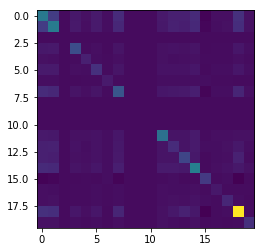

In [109]:
plt.imshow(corex.get_covariance()[:20, :20])
plt.show()

## check gradients

In [ ]:
corex = Corex(**corex_params)

In [ ]:
corex.fit(X)

In [ ]:
corex.moments = corex._calculate_moments_ns(X, corex.ws)
grad = corex._update_ns(X, return_gradient=True)

In [ ]:
old_tc = corex.tc
print old_tc, corex._calculate_moments_ns(X, corex.ws)["TC"]

In [ ]:
num_grad = np.zeros(corex.ws.shape)
delta = 1e-8
for j in range(corex.m):
    print "\rj={}".format(j),
    for i in range(corex.nv):
        corex.ws[j, i] += delta
        new_tc = corex._calculate_moments_ns(X, corex.ws)['TC']
        #print("numerical gradient = {}, corex.grad = {}".format((new_tc - old_tc) / delta, grad[j][i]))
        num_grad[j,i] = (new_tc - old_tc) / delta
        corex.ws[j, i] -= delta

In [ ]:
plt.imshow(np.abs(num_grad / old_grad)[:, :20])
plt.colorbar()
plt.show()